# Exploring the non-stationary nature of air temperature data

## Train a GP

In [172]:
import geopandas as gpd
import torch
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rasterio as rio

city = 'Baltimore'
gdf = gpd.read_file(f'../data/shapefiles/{city}/pm_trav.shp')
gdf.columns

Index(['loctime', 'lat', 'lon', 'hgt', 'speed', 'T', 'geometry'], dtype='object')

In [173]:
gdf.total_bounds
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [175]:
gdf = gdf.to_crs(epsg=3857) # in meters
bounds = gdf.total_bounds
bounds[0]

-8584001.905442396

In [157]:
cd ../src

/Users/edliao/Code/uhi-deep-learning/src


### Visualize city land cover

In [5]:
from utils import custom_colormap

ed


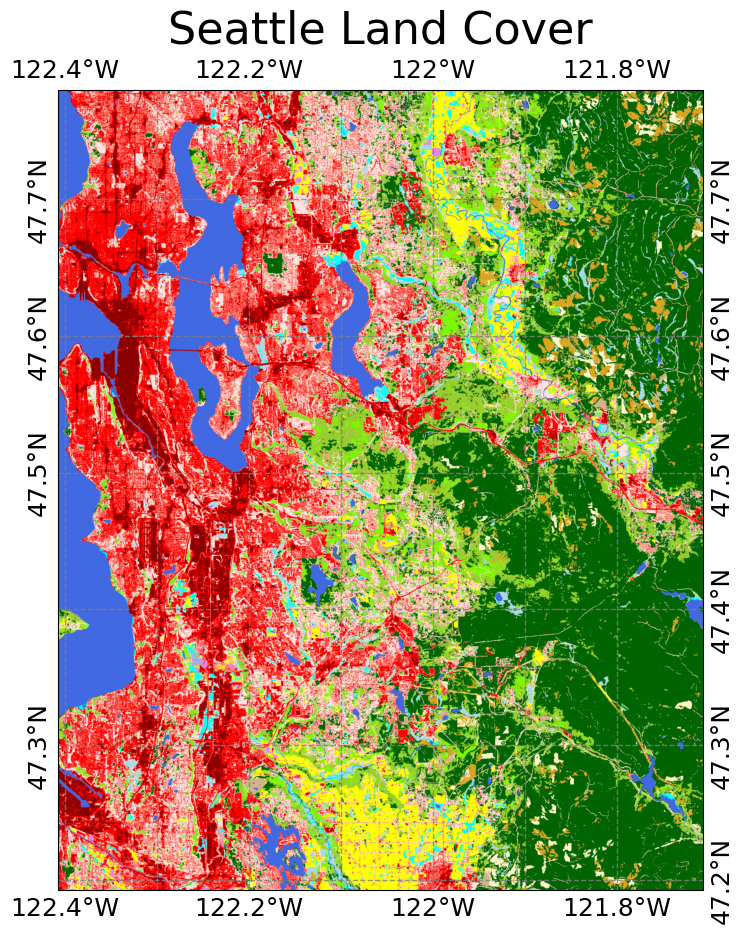

In [6]:
tif_nlcd = f'../data/land/{city}_nlcd.tif'
with rio.open(tif_nlcd) as src:
    nlcd = src.read(1)
    bounds = src.bounds


new_nlcd = nlcd.copy()
for i, j in enumerate(np.unique(nlcd)):
    new_nlcd[nlcd == j] = i

# Generate land cover colormap
fig = plt.figure(figsize=(10, 10))

# Plot the raster data
img_extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ccrs.epsg(3857))
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=0.8, linestyle='--', ylabel_style={'size': 18, 'rotation': 'vertical'}, xlabel_style={'size': 18})

img = plt.imshow(new_nlcd, extent=img_extent, cmap=custom_colormap())

# Add scatter points for the coordinates
# ax.scatter(converted_coordinates[1], converted_coordinates[0], color='black', s=400, transform=ccrs.PlateCarree(), label='Sample Points')

# Add legend for points
# ax.legend(loc='upper right', fontsize=12)

fig.suptitle(f'{city} Land Cover', fontsize=32)

# Save or display the plot
# plt.savefig(f'../figures/{city}_nlcd.png', dpi=300, bbox_inches='tight')
plt.show()

### Data preprocessing

In [158]:
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y
coordinates = gdf[['x', 'y']].to_numpy()
print(coordinates)

[[-8573839.65057333  4709576.43200874]
 [-8573837.54646797  4709575.16536071]
 [-8573832.96331096  4709572.37641213]
 ...
 [-8527554.7027326   4763418.06133923]
 [-8527558.04114847  4763416.41646227]
 [-8527560.28713052  4763415.8497544 ]]


In [160]:
gdf.columns # Check the heading associated with the temperature in Fahrenheit

Index(['loctime', 'lat', 'lon', 'hgt', 'speed', 'T', 'geometry', 'x', 'y'], dtype='object')

Change the units of X from meters to kilometers

In [165]:
gdf['T']

0        31.8
1        31.8
2        31.9
3        31.9
4        31.9
         ... 
50257    32.4
50258    32.3
50259    32.1
50260    32.0
50261    32.0
Name: T, Length: 50262, dtype: float64

In [166]:
# X, y = coordinates, (gdf.T.to_numpy() - 32) * 5.0 / 9.0 # convert to celsius
X, y = coordinates, gdf['T'].to_numpy() # already in celsius
# Now, we need to standardize the data for the final fit
x_shift = X.min(axis=0)
x_scale = X.max(axis=0) - X.min(axis=0)

# Add in a small number 1e-8 to prevent divide by zero errors
x_norm = (X - x_shift) / (x_scale + 1e-16)

# Standardize the labels
y_mean = y.mean()
y_std = y.std()

y_norm = (y - y_mean) / (y_std)

In [167]:
np.unique(y)

array([27.3, 27.4, 27.5, 27.6, 27.7, 27.8, 27.9, 28. , 28.1, 28.2, 28.3,
       28.4, 28.5, 28.6, 28.7, 28.8, 28.9, 29. , 29.1, 29.2, 29.3, 29.4,
       29.5, 29.6, 29.7, 29.8, 29.9, 30. , 30.1, 30.2, 30.3, 30.4, 30.5,
       30.6, 30.7, 30.8, 30.9, 31. , 31.1, 31.2, 31.3, 31.4, 31.5, 31.6,
       31.7, 31.8, 31.9, 32. , 32.1, 32.2, 32.3, 32.4, 32.5, 32.6, 32.7,
       32.8, 32.9, 33. , 33.1, 33.2, 33.3, 33.4, 33.5, 33.6, 33.7, 33.8,
       33.9, 34. , 34.1, 34.2, 34.3, 34.4, 34.5, 34.6, 34.7, 34.8, 34.9,
       35. , 35.1, 35.2, 35.3, 35.4, 35.5, 35.6, 35.7])

Train-test split

In [168]:
import numpy as np
random_indices = np.random.choice(len(X), size=10000, replace=False)

In [169]:
x_tensor, y_tensor = torch.tensor(x_norm[random_indices]), torch.tensor(y_norm[random_indices])

### Visualize train and test data on the map

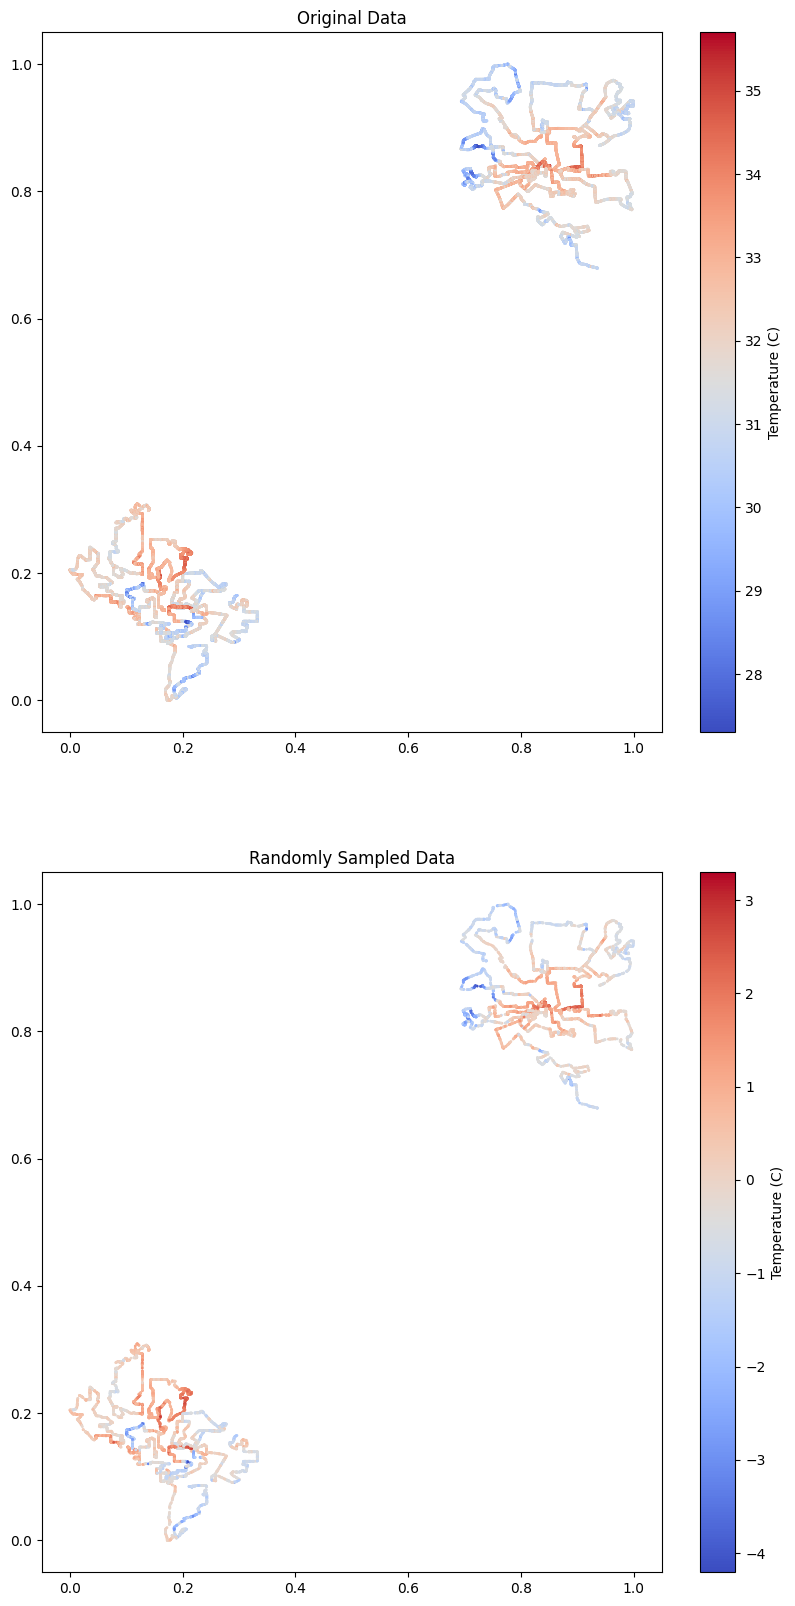

In [171]:
fig, ax = plt.subplots(2, 1, figsize=(10,20))
scatter_orig = ax[0].scatter(x_norm[:, 0], x_norm[:, 1], c=y, cmap='coolwarm', s=1)
ax[0].set_title('Original Data')
fig.colorbar(scatter_orig, ax=ax[0], label='Temperature (C)')

scatter_rand = ax[1].scatter(x_tensor[:, 0], x_tensor[:, 1], c=y_tensor, cmap='coolwarm', s=1)
ax[1].set_title('Randomly Sampled Data')
fig.colorbar(scatter_rand, ax=ax[1], label='Temperature (C)')


### Model training

In [92]:
from models import NonStationaryGPModel, ExactGPModel
import gpytorch
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

Check the presence of GPUs from Apple M4

In [93]:
# Set device: use CUDA if available, fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [94]:
def train_model(X, y, model_str='ExactGP', num_points=16, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_scores = []

    best_val_score = -float('inf')  # Initialize for max R²
    best_model_weights = None
    best_likelihood_weights = None
    best_fold_model = None
    best_fold_likelihood = None

    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}/{n_splits}")

        # Move data to device
        train_x = torch.tensor(X[train_index], dtype=torch.float32).to(device)
        train_y = torch.tensor(y[train_index], dtype=torch.float32).to(device)
        val_x = torch.tensor(X[val_index], dtype=torch.float32).to(device)
        val_y = torch.tensor(y[val_index], dtype=torch.float32).to(device)

        # Initialize likelihood & model
        likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
        # likelihood = gpytorch.likelihoods.StudentTLikelihood()
        if model_str == 'ExactGP':
            model = ExactGPModel(train_x, train_y, likelihood).to(device)
        elif model_str == 'NonStationaryGP':
            model = NonStationaryGPModel(train_x, train_y, likelihood, num_points=num_points).to(device)

        model.train()
        likelihood.train()

        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        best_train_loss = float('inf')
        best_model_state = None

        for i in range(30):
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            optimizer.step()

            print(f"📉 Epoch {i+1}/30 - Loss: {loss.item():.4f}")
            if loss.item() < best_train_loss:
                best_train_loss = loss.item()
                best_model_state = model.state_dict()

        # Evaluate on validation set
        model.load_state_dict(best_model_state)
        model.eval()
        likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            val_pred = likelihood(model(val_x)).mean
            val_r2 = r2_score(val_y.cpu().numpy(), val_pred.cpu().numpy())
            print(f"Validation R² (Fold {fold+1}): {val_r2:.4f}")
            fold_scores.append(val_r2)

            # Track the best-performing model
            if val_r2 > best_val_score:
                best_val_score = val_r2
                best_model_weights = best_model_state
                best_likelihood_weights = likelihood.state_dict()
                best_fold_model = model.__class__  # Save class to reinitialize later
                best_fold_likelihood = likelihood.__class__

    print(f"\nAverage R² across folds: {np.mean(fold_scores):.4f}")
    print(f"Best R² across folds: {best_val_score:.4f}")

    # Re-initialize and load best model and likelihood
    final_likelihood = best_fold_likelihood().to(device)
    if model_str == 'ExactGP':
        final_model = best_fold_model(torch.tensor(X, dtype=torch.float32).to(device),
                                  torch.tensor(y, dtype=torch.float32).to(device),
                                  final_likelihood).to(device)
    elif model_str == 'NonStationaryGP':
        final_model = best_fold_model(torch.tensor(X, dtype=torch.float32).to(device),
                                  torch.tensor(y, dtype=torch.float32).to(device),
                                  final_likelihood, num_points=num_points).to(device)
    final_model.load_state_dict(best_model_weights)
    final_likelihood.load_state_dict(best_likelihood_weights)

    return final_model

In [95]:
# Train the GP model using your Non-Stationary Kernel
exact_gp_model = train_model(x_tensor, y_tensor, 'ExactGP', n_splits=2)
# print('\n')
# ns_gp_model = train_model(x_tensor, y_tensor,'NonStationaryGP', num_points=4, n_splits=2)


Fold 1/2


/var/folders/mn/mv85f3qn4b3fq8hnthx7qfdm0000gn/T/ipykernel_78428/1839536043.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_x = torch.tensor(X[train_index], dtype=torch.float32).to(device)
/var/folders/mn/mv85f3qn4b3fq8hnthx7qfdm0000gn/T/ipykernel_78428/1839536043.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(y[train_index], dtype=torch.float32).to(device)
/var/folders/mn/mv85f3qn4b3fq8hnthx7qfdm0000gn/T/ipykernel_78428/1839536043.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_x = torch.t

📉 Epoch 1/30 - Loss: 1.3856
📉 Epoch 2/30 - Loss: 1.3752
📉 Epoch 3/30 - Loss: 1.3684
📉 Epoch 4/30 - Loss: 1.3644
📉 Epoch 5/30 - Loss: 1.3624
📉 Epoch 6/30 - Loss: 1.3618
📉 Epoch 7/30 - Loss: 1.3610
📉 Epoch 8/30 - Loss: 1.3597
📉 Epoch 9/30 - Loss: 1.3579
📉 Epoch 10/30 - Loss: 1.3555
📉 Epoch 11/30 - Loss: 1.3522
📉 Epoch 12/30 - Loss: 1.3489
📉 Epoch 13/30 - Loss: 1.3437
📉 Epoch 14/30 - Loss: 1.3402
📉 Epoch 15/30 - Loss: 1.3337
📉 Epoch 16/30 - Loss: 1.3307
📉 Epoch 17/30 - Loss: 1.3273
📉 Epoch 18/30 - Loss: 1.3243
📉 Epoch 19/30 - Loss: 1.3224
📉 Epoch 20/30 - Loss: 1.3233
📉 Epoch 21/30 - Loss: 1.3215
📉 Epoch 22/30 - Loss: 1.3240
📉 Epoch 23/30 - Loss: 1.3247
📉 Epoch 24/30 - Loss: 1.3262
📉 Epoch 25/30 - Loss: 1.3271
📉 Epoch 26/30 - Loss: 1.3218
📉 Epoch 27/30 - Loss: 1.3248
📉 Epoch 28/30 - Loss: 1.3258
📉 Epoch 29/30 - Loss: 1.3267
📉 Epoch 30/30 - Loss: 1.3206
Validation R² (Fold 1): 0.2765

Fold 2/2


/var/folders/mn/mv85f3qn4b3fq8hnthx7qfdm0000gn/T/ipykernel_78428/1839536043.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_x = torch.tensor(X[train_index], dtype=torch.float32).to(device)
/var/folders/mn/mv85f3qn4b3fq8hnthx7qfdm0000gn/T/ipykernel_78428/1839536043.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(y[train_index], dtype=torch.float32).to(device)
/var/folders/mn/mv85f3qn4b3fq8hnthx7qfdm0000gn/T/ipykernel_78428/1839536043.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_x = torch.t

📉 Epoch 1/30 - Loss: 1.4726
📉 Epoch 2/30 - Loss: 1.4558
📉 Epoch 3/30 - Loss: 1.4432
📉 Epoch 4/30 - Loss: 1.4337
📉 Epoch 5/30 - Loss: 1.4275
📉 Epoch 6/30 - Loss: 1.4231
📉 Epoch 7/30 - Loss: 1.4203
📉 Epoch 8/30 - Loss: 1.4195
📉 Epoch 9/30 - Loss: 1.4177
📉 Epoch 10/30 - Loss: 1.4157
📉 Epoch 11/30 - Loss: 1.4140
📉 Epoch 12/30 - Loss: 1.4107
📉 Epoch 13/30 - Loss: 1.4083
📉 Epoch 14/30 - Loss: 1.4048
📉 Epoch 15/30 - Loss: 1.3978
📉 Epoch 16/30 - Loss: 1.3912
📉 Epoch 17/30 - Loss: 1.3857
📉 Epoch 18/30 - Loss: 1.3765
📉 Epoch 19/30 - Loss: 1.3684
📉 Epoch 20/30 - Loss: 1.3571
📉 Epoch 21/30 - Loss: 1.3494
📉 Epoch 22/30 - Loss: 1.3357
📉 Epoch 23/30 - Loss: 1.3231
📉 Epoch 24/30 - Loss: 1.3067
📉 Epoch 25/30 - Loss: 1.2866
📉 Epoch 26/30 - Loss: 1.2616
📉 Epoch 27/30 - Loss: 1.2420
📉 Epoch 28/30 - Loss: 1.2185
📉 Epoch 29/30 - Loss: 1.2012
📉 Epoch 30/30 - Loss: 1.1746
Validation R² (Fold 2): 0.2695

Average R² across folds: 0.2730
Best R² across folds: 0.2765


/var/folders/mn/mv85f3qn4b3fq8hnthx7qfdm0000gn/T/ipykernel_78428/1839536043.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_model = best_fold_model(torch.tensor(X, dtype=torch.float32).to(device),
/var/folders/mn/mv85f3qn4b3fq8hnthx7qfdm0000gn/T/ipykernel_78428/1839536043.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y, dtype=torch.float32).to(device),


### Model evaluation

In [72]:
def generate_predictions(model, likelihood, points, num_samples=4, y_mean=0.0, y_std=1.0):
    """
    Generate 1 mean and `num_samples` sampled predictions from the posterior.
    Applies unnormalization using provided mean and std of original y.

    Returns:
        mean_pred: [num_points]
        sample_preds: [num_samples, num_points]
    """
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predictive_dist = likelihood(model(points))  # GP predictive distribution

        # Posterior mean (unnormalized)
        mean_pred = predictive_dist.mean.cpu().numpy() * y_std + y_mean

        # Posterior samples (unnormalized)
        sample_preds = predictive_dist.rsample(torch.Size([num_samples]))  # [num_samples, num_points]
        sample_preds = sample_preds.cpu().numpy() * y_std + y_mean

    return mean_pred, sample_preds

Sampling points from the GP

How do we sample points from GP?
- 100m resolution -> 10 Hz (10 samples/km)

How many samples is enough to generate a relibale Fourier analysis?
Cool figure: generate 10 different samples

create a dataloader to send batches of samples at a time!

visualize the standard deviation that can be an additional point of analysis when looking at the dominant frequencies in each city

Generated 1813 points with 500m resolution


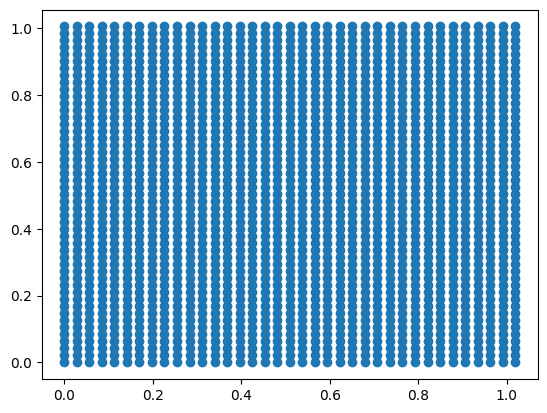

In [73]:
# Bounding box coordinates in kilometers
xmin, ymin, xmax, ymax = bounds

# xmax = (xmax+xmin)/2
# ymin = (ymax+ymin)/2

resolution = 500 # meters

# Generate coordinate grid
x_coords = np.arange(xmin, xmax + resolution, resolution)
x_coords_norm = (x_coords - x_shift[0]) / (x_scale[0] + 1e-16)
y_coords = np.arange(ymin, ymax + resolution, resolution)
y_coords_norm = (y_coords - x_shift[1]) / (x_scale[1] + 1e-16)
X, Y = np.meshgrid(x_coords_norm, y_coords_norm)

# Combine into (N, 2) array of 2D points
points = np.vstack([X.ravel(), Y.ravel()]).T

print(f"Generated {points.shape[0]} points with {int(resolution)}m resolution")
plt.scatter(points[:, 0], points[:, 1])

In [74]:
points = torch.tensor(points, dtype=torch.float32)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Generate predictions for sampled points
mean_pred_ex, sample_preds_ex = generate_predictions(exact_gp_model, likelihood, points, num_samples=2, y_std=y_std, y_mean=y_mean)
# mean_pred_ns, sample_preds_ns = generate_predictions(ns_gp_model, likelihood, points, num_samples=2, y_std=y_std, y_mean=y_mean)

# mean_pred_ns, sample_preds_ns

Visualize sampled points from GP

### Detrend sample GP (before subjecting to Fourier transform)

In [75]:
from sklearn.linear_model import LinearRegression
import numpy as np

def detrend_2d_surface(Z):
    """
    Removes the best-fit plane from a 2D array Z.

    Parameters:
        Z (2D array): The surface to detrend.

    Returns:
        detrended (2D array): Z with the linear trend removed.
        trend (2D array): The fitted linear trend (plane).
    """
    Ny, Nx = Z.shape
    x, y = np.meshgrid(np.arange(Nx), np.arange(Ny))  # X and Y grid coordinates

    # Flatten everything for regression
    X_flat = np.column_stack((x.ravel(), y.ravel(), np.ones(Nx * Ny)))
    Z_flat = Z.ravel()

    # Fit plane
    model = LinearRegression().fit(X_flat, Z_flat)
    trend_flat = model.predict(X_flat)
    trend = trend_flat.reshape(Z.shape)

    # Subtract trend
    detrended = Z - trend
    return detrended, trend

In [76]:
z1 = np.flipud(mean_pred_ex.reshape(len(y_coords), len(x_coords)))
gp_sample1, trend = detrend_2d_surface(z1)

In [81]:
gp_sample1

array([[ 0.22358059,  0.36058494,  0.49788302, ..., -0.5299974 ,
        -0.54879864, -0.56759797],
       [ 0.28954459,  0.56299495,  0.93467185, ..., -0.51667431,
        -0.53547555, -0.55427678],
       [ 0.31760195,  0.70295264,  1.43354296, ..., -0.50334931,
        -0.52215245, -0.54095369],
       ...,
       [ 0.79004084,  0.77220281,  0.60800249, ...,  0.08277518,
         0.06397585,  0.04517652],
       [ 0.34598554,  0.60058366,  0.5867587 , ...,  0.09609636,
         0.07729704,  0.05849771],
       [ 0.39373055,  0.53699101,  0.57364212, ...,  0.10941755,
         0.09061822,  0.07181889]])

In [82]:
from sklearn.linear_model import LinearRegression

def detrend_2d(X, Y, Z):
    
    # Flatten inputs
    Z_flat = Z.ravel()
    
    # Design matrix for a plane: z = ax + by + c
    A = np.vstack([X, Y, np.ones_like(X)]).T
    model = LinearRegression().fit(A, Z_flat)
    
    # Predict trend surface
    trend = model.predict(A).reshape(Z.shape)
    
    # Subtract trend
    detrended = Z - trend
    return detrended, trend

z1 = np.flipud(mean_pred_ex.reshape(len(y_coords), len(x_coords)))
gp_sample1, trend = detrend_2d(points[:, 0], points[:, 1], z1)

In [83]:
gp_sample1

array([[ 0.2235794 ,  0.36058426,  0.49788094, ..., -0.5299988 ,
        -0.5487995 , -0.56759834],
       [ 0.28954315,  0.562994  ,  0.9346714 , ..., -0.51667595,
        -0.5354767 , -0.5542774 ],
       [ 0.31760025,  0.70295143,  1.4335423 , ..., -0.5033512 ,
        -0.52215385, -0.5409546 ],
       ...,
       [ 0.79003906,  0.77220154,  0.6080017 , ...,  0.08277321,
         0.06397438,  0.04517555],
       [ 0.3459835 ,  0.6005821 ,  0.58675766, ...,  0.09609604,
         0.0772953 ,  0.05849648],
       [ 0.39373016,  0.5369892 ,  0.5736408 , ...,  0.10941696,
         0.09061623,  0.0718174 ]], dtype=float32)

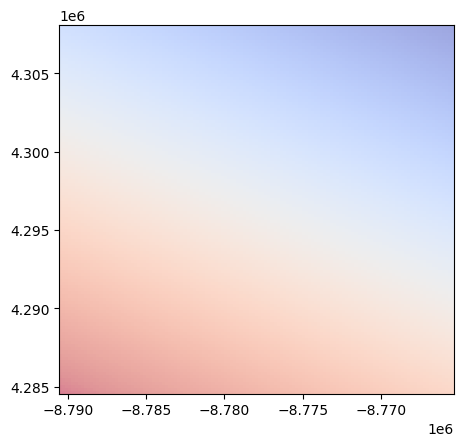

In [98]:
plt.imshow(trend, extent=(x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()), cmap='coolwarm', alpha=0.5)

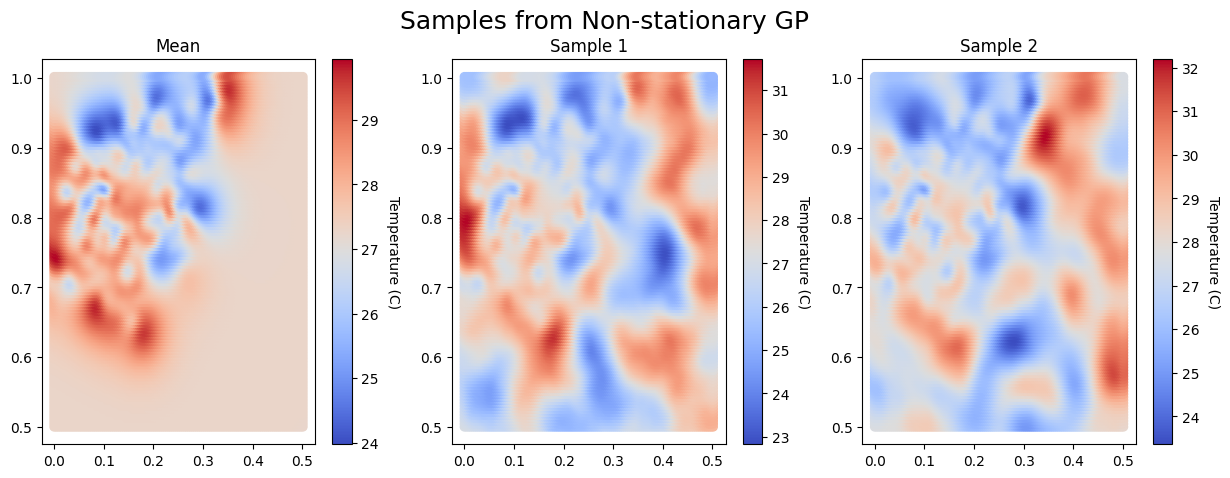

In [87]:
# Plot the results
fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('Samples from Non-stationary GP', fontsize=18)
ax[0].scatter(points[:, 0], points[:, 1], c=mean_pred_ex.flatten(), cmap="coolwarm")# vmin=24, vmax=34)
colorbar = fig.colorbar(ax[0].collections[0], ax=ax[0], label='Temperature (C)')
colorbar.set_label('Temperature (C)', rotation=270, labelpad=15)
ax[0].set_title('Mean')

ax[1].scatter(points[:, 0], points[:, 1], c=sample_preds_ex[0], cmap="coolwarm") #, vmin=24, vmax=34)
ax[1].set_title('Sample 1')
colorbar = fig.colorbar(ax[1].collections[0], ax=ax[1], label='Temperature (C)')
colorbar.set_label('Temperature (C)', rotation=270, labelpad=15)

ax[2].scatter(points[:, 0], points[:, 1], c=sample_preds_ex[1], cmap="coolwarm")
ax[2].set_title('Sample 2')
colorbar = fig.colorbar(ax[2].collections[0], ax=ax[2], label='Temperature (C)')
colorbar.set_label('Temperature (C)', rotation=270, labelpad=15)
plt.show()


#### Visualized predictions on train and test data locations

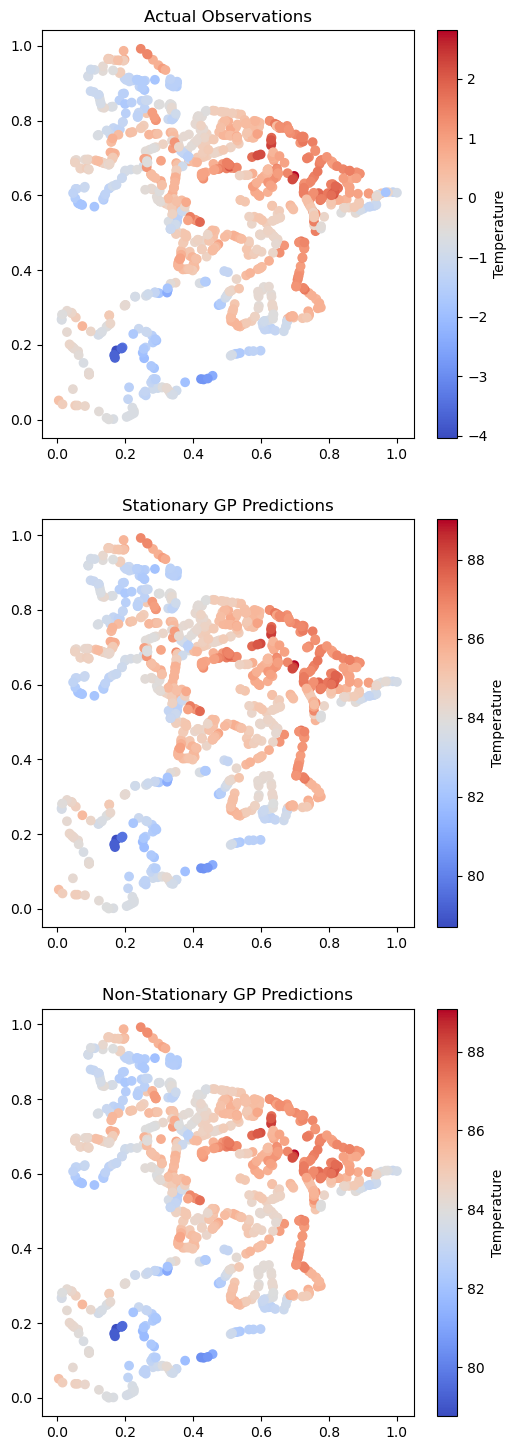

In [20]:
import matplotlib.pyplot as plt

# Create side-by-side contour plots
fig, ax = plt.subplots(3, 1, figsize=(6, 18))

# Contour plot for actual observations
contour0 = ax[0].scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap="coolwarm")
fig.colorbar(contour0, ax=ax[0], label="Temperature")
ax[0].set_title("Actual Observations")

# Contour plot for Exact (Stationary) GP
contour1 = ax[1].scatter(x_test[: ,0], x_test[:, 1], c=y_pred, cmap="coolwarm")
fig.colorbar(contour1, ax=ax[1], label="Temperature")
ax[1].set_title("Stationary GP Predictions")

# Contour plot for Non-Stationary GP
contour2 = ax[2].scatter(x_test[:, 0], x_test[:, 1], c=y_pred_ns, cmap="coolwarm")
fig.colorbar(contour2, ax=ax[2], label="Temperature")
ax[2].set_title("Non-Stationary GP Predictions")

plt.show()


## GP model comparisons

Atlanta (9 fixed points)

In [19]:
from sklearn.metrics import mean_squared_error, r2_score

# Compute RMSE between true function values and GP predicted mean
rmse = np.sqrt(mean_squared_error(y[test_indices], y_pred))
r2 = r2_score(y[test_indices], y_pred)
rmse_ns = np.sqrt(mean_squared_error(y[test_indices], y_pred_ns))
r2_ns = r2_score(y[test_indices], y_pred_ns)

# Print performance metrics
print(f'Exact GP RMSE: {rmse:.2f}')
print(f'Exact GP R^2: {r2:.4f}')
print(f'Non-Stationary GP RMSE: {rmse_ns:.2f}')
print(f'Non-Stationary GP R^2: {r2_ns:.4f}')

Exact GP RMSE: 0.35
Exact GP R^2: 0.9808
Non-Stationary GP RMSE: 0.45
Non-Stationary GP R^2: 0.9686


Atlanta (4 fixed points)

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

# Compute RMSE between true function values and GP predicted mean
rmse = np.sqrt(mean_squared_error(y[test_indices], y_pred))
r2 = r2_score(y[test_indices], y_pred)
rmse_ns = np.sqrt(mean_squared_error(y[test_indices], y_pred_ns))
r2_ns = r2_score(y[test_indices], y_pred_ns)

# Print performance metrics
print(f'Exact GP RMSE: {rmse:.2f}')
print(f'Exact GP R^2: {r2:.4f}')
print(f'Non-Stationary GP RMSE: {rmse_ns:.2f}')
print(f'Non-Stationary GP R^2: {r2_ns:.4f}')

Exact GP RMSE: 0.36
Exact GP R^2: 0.9805
Non-Stationary GP RMSE: 0.41
Non-Stationary GP R^2: 0.9747


Atlanta (1 fixed point)

In [126]:
from sklearn.metrics import mean_squared_error, r2_score

# Compute RMSE between true function values and GP predicted mean
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y[test_indices], y_pred)
rmse_ns = np.sqrt(mean_squared_error(y[test_indices], y_pred_ns))
r2_ns = r2_score(y[test_indices], y_pred_ns)

# Print performance metrics
print(f'Exact GP RMSE: {rmse:.2f}')
print(f'Exact GP R^2: {r2:.4f}')
print(f'Non-Stationary GP RMSE: {rmse_ns:.2f}')
print(f'Non-Stationary GP R^2: {r2_ns:.4f}')

Exact GP RMSE: 0.47
Exact GP R^2: 0.9647
Non-Stationary GP RMSE: 0.49
Non-Stationary GP R^2: 0.9613


Boston (9 fixed points)

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

# Compute RMSE between true function values and GP predicted mean
rmse = np.sqrt(mean_squared_error(y[test_indices], y_pred))
r2 = r2_score(y[test_indices], y_pred)
rmse_ns = np.sqrt(mean_squared_error(y[test_indices], y_pred_ns))
r2_ns = r2_score(y[test_indices], y_pred_ns)

# Print performance metrics
print(f'Exact GP RMSE: {rmse:.2f}')
print(f'Exact GP R^2: {r2:.4f}')
print(f'Non-Stationary GP RMSE: {rmse_ns:.2f}')
print(f'Non-Stationary GP R^2: {r2_ns:.4f}')

Exact GP RMSE: 0.20
Exact GP R^2: 0.9829
Non-Stationary GP RMSE: 0.24
Non-Stationary GP R^2: 0.9747


## Alternative way of measuring non-stationarity
[1] M. M. Noack, H. Luo, and M. D. Risser, “A unifying perspective on non-stationary kernels for deeper Gaussian processes,” APL Machine Learning, vol. 2, no. 1, p. 010902, Feb. 2024, doi: 10.1063/5.0176963.

In [55]:
import torch
import numpy as np
import gpytorch
# Define ExactGPModel (required for Gaussian Process regression)
class StationaryGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(StationaryGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Function to estimate GP hyperparameters in local subdomains
def measure_nonstationarity(X, y, m=10, size=0.2, c=50):
    """
    X: Coordinates (Nx2 matrix of lat/lon)
    y: Temperature values (Nx1)
    m: Number of iterations
    size: Size of the subdomain (percentage)
    c: Number of selected points in each iteration
    """
    length_scales = []
    signal_variances = []
    final_loss = []
    noises = []

    fig, ax = plt.subplots(m,1, figsize = (18, 3))

    for i in range(m):
        # Select a random subdomain
        # a = np.random.uniform(0, 1 - size, X.shape[1])  # Start point
        a = np.random.uniform(0, 1 - size)
        b = a + size  # End point

        # Find points within the subdomain
        # mask = np.all((X >= a) & (X <= b), axis=1)
        mask = (X >= a) & (X <= b)
        subdomain_points = X[mask]
        subdomain_values = y[mask]


        if len(subdomain_points) < c:
            continue  # Skip if not enough points

        # Randomly sample c points from the subdomain
        # indices = np.random.uniform.choice(len(subdomain_points), c, replace=False)

        # Sample `c` random indices from a uniform distribution
        indices = np.random.uniform(0, len(subdomain_points), c).astype(int)

        # Ensure indices are within valid range
        # indices = np.clip(indices, 0, len(subdomain_points) - 1)
        X_t = torch.tensor(subdomain_points[indices], dtype=torch.float32)
        y_t = torch.tensor(subdomain_values[indices], dtype=torch.float32)
        ax[i].scatter(X_t, y_t)
        # print(X_t)
        # print(y_t)
        # plt.plot(X_t, y_t)

        # Fit a stationary GP
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = StationaryGPModel(X_t, y_t, likelihood)
        model.train()
        likelihood.train()

        # Optimize GP hyperparameters using MLE
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for _ in range(20):  # Small training loop
            optimizer.zero_grad()
            output = model(X_t)
            loss = -mll(output, y_t)
            loss.backward()
            optimizer.step()

        # Extract hyperparameters
        signal_variance = model.covar_module.outputscale.item()
        length_scale = model.covar_module.base_kernel.lengthscale.item()

        # Store results
        signal_variances.append(signal_variance)
        length_scales.append(length_scale)
        loss = -mll(output, y_t)
        final_loss.append(loss.item())
        noises.append(model.likelihood.noise.item())
    
    plt.tight_layout
    plt.show()

    return signal_variances, length_scales, final_loss, noises

In [27]:
# Example usage with synthetic data
np.random.seed(42)
num_points = 1000
X = np.random.rand(num_points, 2)  # Random latitude/longitude
y = np.sin(10 * X[:, 0]) + np.cos(10 * X[:, 1]) + 0.1 * np.random.randn(num_points)  # Synthetic temperature

In [30]:
X.shape, y.shape

((1000, 2), (1000,))

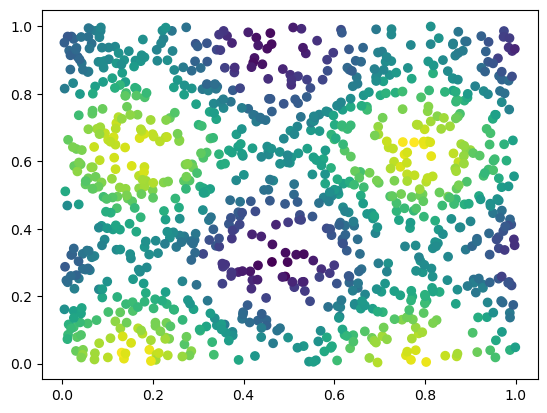

In [34]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap = 'viridis')

In [44]:
signal_variances, length_scales = measure_nonstationarity(X, y, m=20, size=0.3, c=50)

# Print results
print(f"Signal Variances: {str(signal_variances)}")
print(f"Length Scales: {str(length_scales)}")
print(f"Mean Signal Variance: {np.mean(signal_variances):.3f}")
print(f"Mean Length Scale: {np.mean(length_scales):.3f}")
print(f"Signal Variance Spread: {np.std(signal_variances)}")
print(f"Length Scale Spread: {np.std(length_scales)}")

Signal Variances: [1.5350335836410522, 1.3764780759811401, 0.7179362773895264, 1.327297568321228, 1.625792145729065, 1.6714972257614136, 1.6693668365478516, 1.6207534074783325, 0.25020188093185425, 1.6944141387939453, 1.6549832820892334, 1.4861334562301636, 1.2567474842071533, 1.6673808097839355, 1.3307722806930542, 1.6641300916671753, 1.6532402038574219, 1.6764358282089233, 1.6870800256729126, 1.4321790933609009]
Length Scales: [0.23765793442726135, 0.2466670423746109, 0.14433343708515167, 0.23206186294555664, 0.22670765221118927, 0.2197967767715454, 0.21856962144374847, 0.23107708990573883, 0.3907795250415802, 0.22523453831672668, 0.21887873113155365, 0.2243974357843399, 0.26619952917099, 0.21705937385559082, 0.24708515405654907, 0.24016842246055603, 0.2497338503599167, 0.24051934480667114, 0.24717497825622559, 0.21177330613136292]
Mean Signal Variance: 1.450
Mean Length Scale: 0.237
Signal Variance Spread: 0.35757525946486735
Length Scale Spread: 0.042444888321756996


### Testing it on Boston Data

In [48]:
X, y = coordinates, gdf.T_F.to_numpy()

In [66]:
x_norm.shape, y_norm.shape

((20247, 2), (20247,))

In [84]:
signal_variances, length_scales = measure_nonstationarity(x_norm, y_norm, m=100, size=0.5, c=400)

In [82]:
# Print results
print(f"Signal Variances: {str(signal_variances)}")
print(f"Length Scales: {str(length_scales)}")
print(f"Mean Signal Variance: {np.mean(signal_variances):.3f}")
print(f"Mean Length Scale: {np.mean(length_scales):.3f}")
print(f"Signal Variance Spread: {np.std(signal_variances)}")
print(f"Length Scale Spread: {np.std(length_scales)}")

Signal Variances: [2.1775684356689453, 2.2069015502929688, 2.048252582550049, 2.2012429237365723, 2.1484756469726562, 2.1692111492156982, 2.1968343257904053, 1.9553534984588623, 2.211698532104492, 2.1517984867095947, 2.036198616027832, 2.1428921222686768, 2.205437183380127, 2.193537712097168, 2.1373231410980225, 2.1486270427703857, 2.206948757171631, 2.0498454570770264, 2.1659083366394043, 2.1731655597686768, 2.1971523761749268, 2.174543619155884, 2.132944107055664, 2.078007698059082, 2.1645667552948, 2.109733819961548, 2.183518409729004, 2.143648624420166, 2.1087021827697754, 2.137377977371216, 2.141129732131958, 2.2064666748046875, 2.188169479370117, 2.186809778213501, 2.147036075592041, 2.2109410762786865, 2.1799240112304688, 2.179713487625122, 2.0379865169525146, 2.2080628871917725, 2.1638801097869873, 2.108712911605835, 2.1871845722198486, 2.1827304363250732, 2.1625473499298096, 2.188783645629883, 2.183311700820923, 2.1703402996063232, 2.1420445442199707, 2.1790549755096436, 2.082

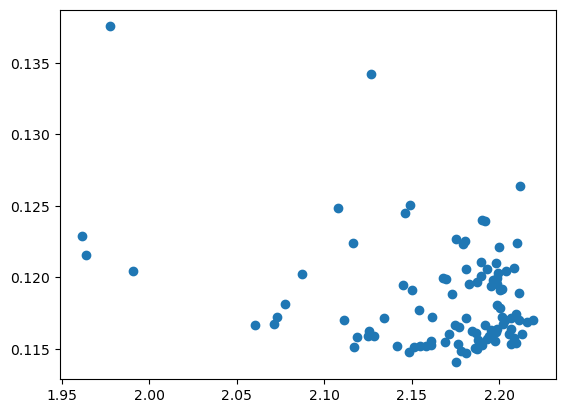

In [85]:
plt.scatter(signal_variances, length_scales)

### Testing it on synthetic data

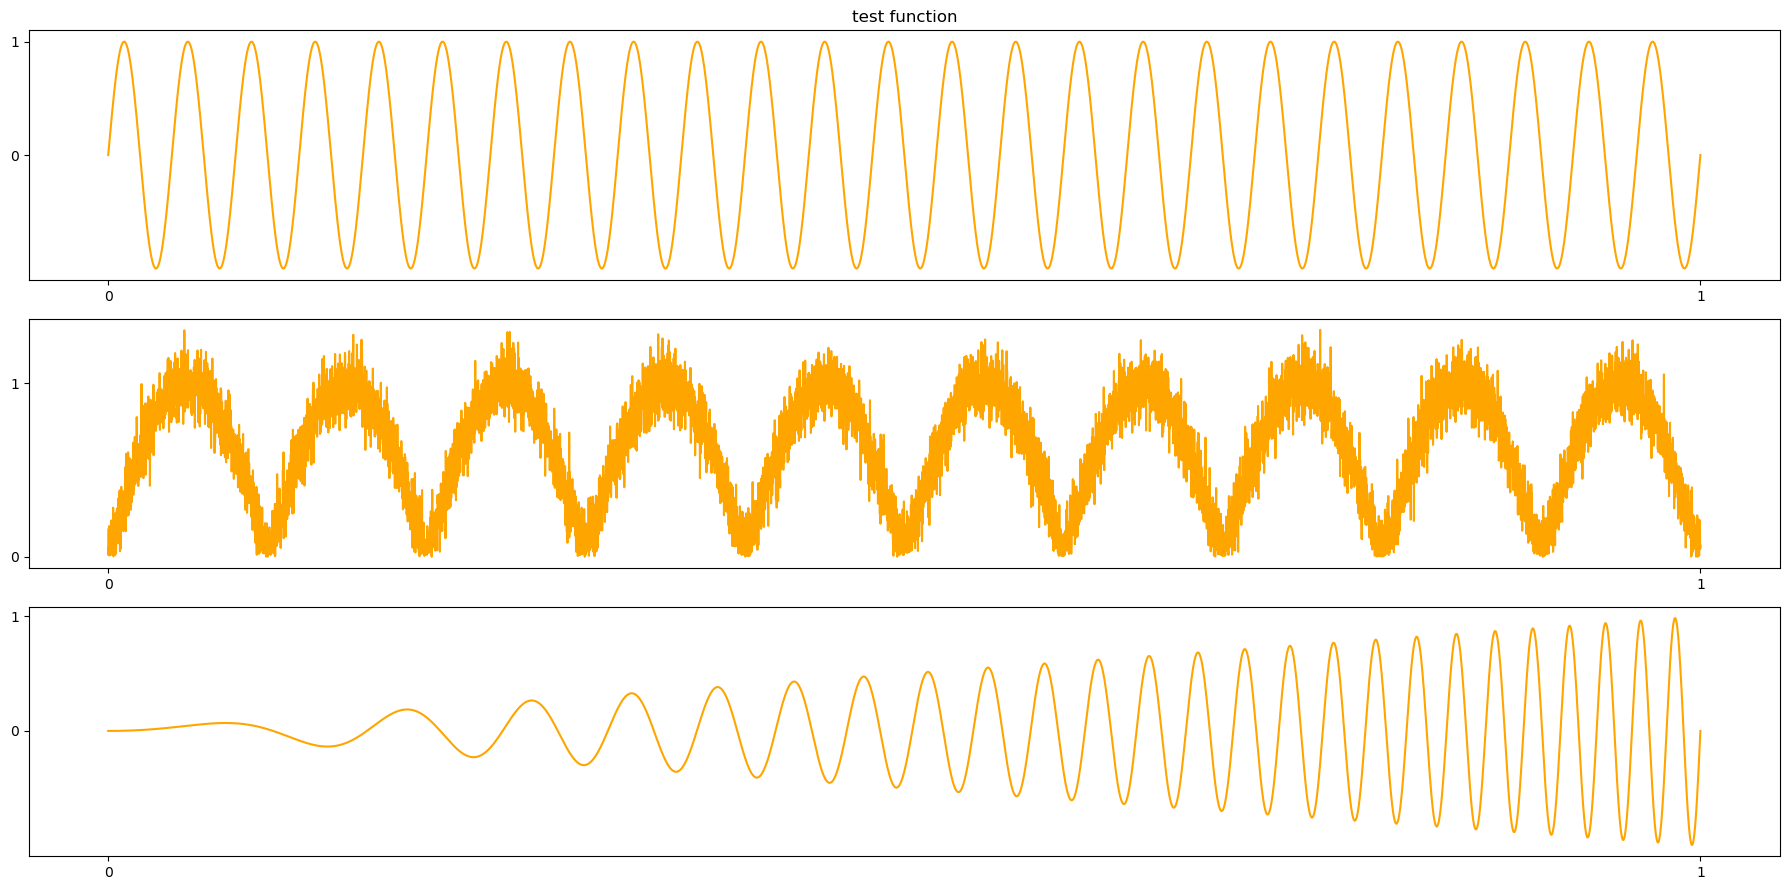

In [31]:
# Generate X values (uniformly spaced)
X = np.linspace(0, 1, 10000)

# Function 1: High-Frequency Sine Wave
y1 = np.sin(50 * np.pi * X)  # High-frequency oscillations

# Function 2: Randomized Sinusoidal Variation
np.random.seed(42)
y2 = np.abs(np.sin(10 * np.pi * X) + 0.1 * np.random.randn(len(X)))  # Random noise added

# Function 3: Increasing Frequency Sine Wave
y3 = X*np.sin((5 + 45 * X) * np.pi * X)  # Frequency increases with X

# Plot the functions
fig, axes = plt.subplots(3, 1, figsize=(18, 9))

axes[0].plot(X, y1, color='orange')
axes[0].set_title("test function")
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])

axes[1].plot(X, y2, color='orange')
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])

axes[2].plot(X, y3, color='orange')
axes[2].set_xticks([0, 1])
axes[2].set_yticks([0, 1])

plt.tight_layout()
plt.show()


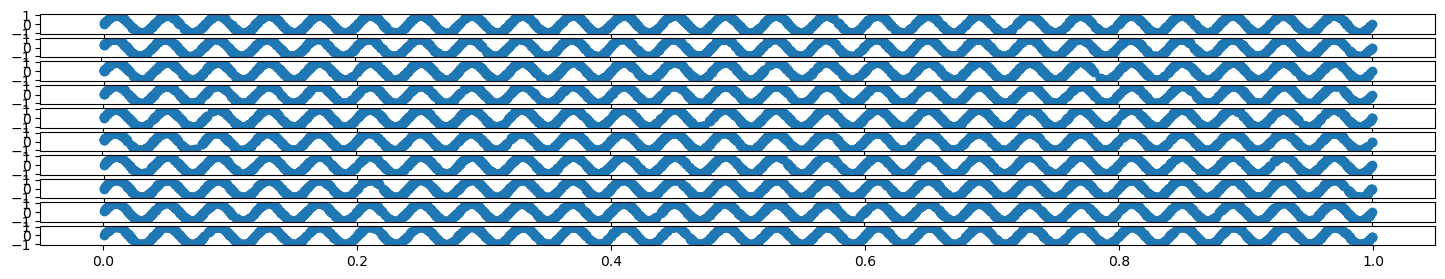

[0.13310083746910095, 0.127107635140419, 0.1253567934036255, 0.1297520399093628, 0.12657666206359863, 0.12364385277032852, 0.12656117975711823, 0.12795747816562653, 0.1334500014781952, 0.1314765065908432]
[1.8366849422454834, 2.021933078765869, 0.41293570399284363, 1.9234288930892944, 2.0683183670043945, 0.4512723386287689, 0.44352856278419495, 1.9791139364242554, 1.846627950668335, 1.889153242111206]
[1.073108196258545, 1.0836201906204224, 1.07779061794281, 1.0830867290496826, 1.0841366052627563, 1.085180640220642, 1.0777355432510376, 1.0768030881881714, 1.066002607345581, 1.0768349170684814]
[0.5387679934501648, 0.5481947064399719, 0.5416252017021179, 0.5475457310676575, 0.5484298467636108, 0.5480217933654785, 0.5416538119316101, 0.5423159003257751, 0.5316483974456787, 0.5422419309616089]


In [57]:
signal_variances, length_scales, losses, noises = measure_nonstationarity(X, y1, m=10, size=1, c=2000)
print(signal_variances)
print(length_scales)
print(losses)
print(noises)

In [188]:
# Print results
print(f"Signal Variances: {str(signal_variances)}")
print(f"Length Scales: {str(length_scales)}")
print(f"Mean Signal Variance: {np.mean(signal_variances):.3f}")
print(f"Mean Length Scale: {np.mean(length_scales):.3f}")
print(f"Signal Variance Spread: {np.std(signal_variances)}")
print(f"Length Scale Spread: {np.std(length_scales)}")

Signal Variances: [0.012337427586317062, 0.01203752588480711, 0.013463904149830341, 0.01811106503009796, 0.014712126925587654, 0.010844042524695396, 0.03671141713857651, 0.010478922165930271, 0.008174744434654713, 0.05806572735309601, 0.012373765930533409, 0.01156712882220745, 0.0319109782576561, 0.010804364457726479, 0.024552877992391586, 0.010748491622507572, 0.010105349123477936, 0.012361808679997921, 0.05041833594441414, 0.03123139776289463, 0.014349742792546749, 0.014037473127245903, 0.0119924396276474, 0.024201884865760803, 0.015393434092402458, 0.012403889559209347, 0.00904550589621067, 0.011953729204833508, 0.009779841639101505, 0.012289202772080898, 0.01568571850657463, 0.011794432997703552, 0.015393105335533619, 0.010253640823066235, 0.01902669668197632, 0.01194808166474104, 0.011938808485865593, 0.011034958995878696, 0.013251381926238537, 0.015552560798823833, 0.012666154652833939, 0.012472865171730518, 0.01192287728190422, 0.013566347770392895, 0.013371833600103855, 0.00669

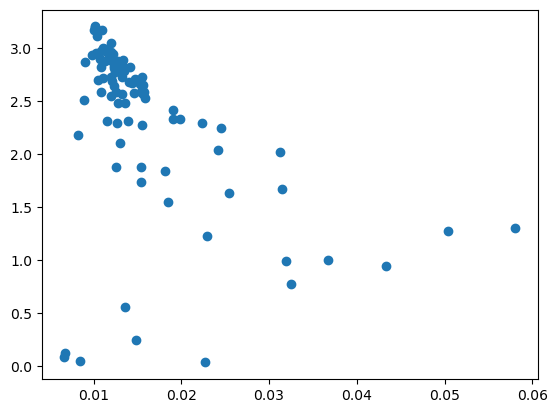

In [189]:
plt.scatter(signal_variances, length_scales)

In [202]:
# Fit a stationary GP
X = torch.tensor(X)
y1 = torch.tensor(y1)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X, y1, likelihood)
model.train()
likelihood.train()

# Optimize GP hyperparameters using MLE
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for _ in range(50):  # Small training loop
    optimizer.zero_grad()
    output = model(X)
    loss = -mll(output, y1)
    loss.backward()
    optimizer.step()

# Extract hyperparameters
signal_variance = model.covar_module.outputscale.item()
length_scale = model.covar_module.base_kernel.lengthscale.item()

print(signal_variance)
print(length_scale)

/var/folders/vf/lbwx_pzs6sq_d5d_w0fcr2zm0000gn/T/ipykernel_9816/2770654842.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
/var/folders/vf/lbwx_pzs6sq_d5d_w0fcr2zm0000gn/T/ipykernel_9816/2770654842.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y1 = torch.tensor(y1)


0.013034552335739136
2.815667152404785


## Using Fourier transforms to extrapolate length scales from the GP

### Synthetic data (longer length scale)

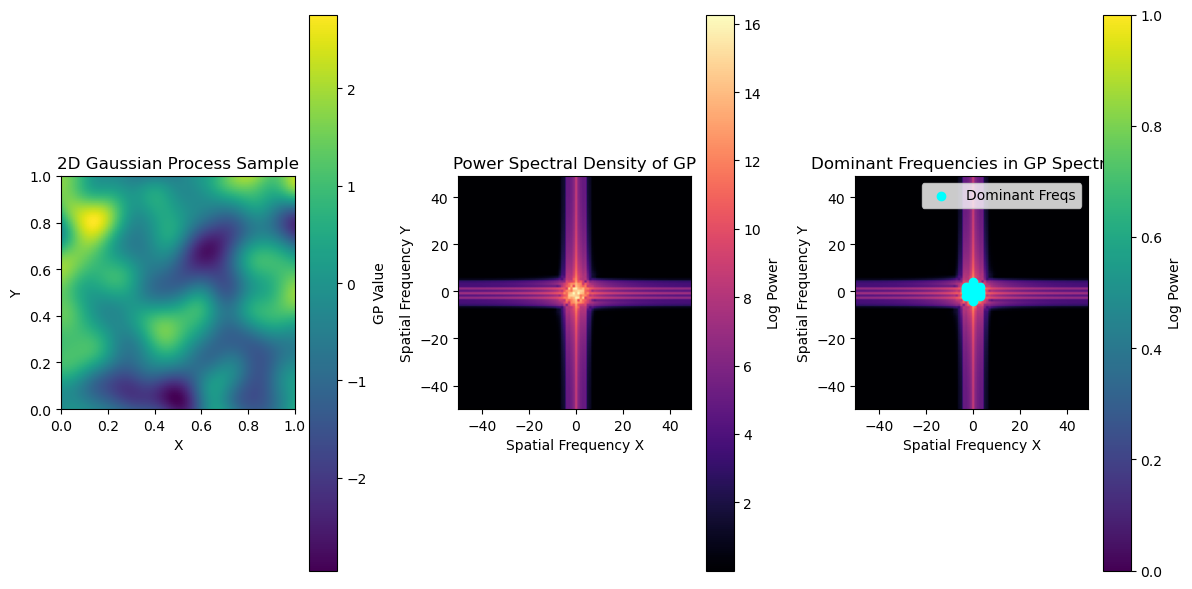

(np.float64(-1.0),
 np.float64(0.0),
 [(np.float64(0.0), np.float64(-4.0)),
  (np.float64(0.0), np.float64(-3.0)),
  (np.float64(-3.0), np.float64(-2.0)),
  (np.float64(-1.0), np.float64(-2.0)),
  (np.float64(0.0), np.float64(-2.0)),
  (np.float64(1.0), np.float64(-2.0)),
  (np.float64(3.0), np.float64(-2.0)),
  (np.float64(-1.0), np.float64(-1.0)),
  (np.float64(0.0), np.float64(-1.0)),
  (np.float64(1.0), np.float64(-1.0)),
  (np.float64(2.0), np.float64(-1.0)),
  (np.float64(3.0), np.float64(-1.0)),
  (np.float64(-3.0), np.float64(0.0)),
  (np.float64(-2.0), np.float64(0.0)),
  (np.float64(-1.0), np.float64(0.0)),
  (np.float64(0.0), np.float64(0.0)),
  (np.float64(1.0), np.float64(0.0)),
  (np.float64(2.0), np.float64(0.0)),
  (np.float64(3.0), np.float64(0.0)),
  (np.float64(-3.0), np.float64(1.0)),
  (np.float64(-2.0), np.float64(1.0)),
  (np.float64(-1.0), np.float64(1.0)),
  (np.float64(0.0), np.float64(1.0)),
  (np.float64(1.0), np.float64(1.0)),
  (np.float64(-3.0), np.float6

In [58]:
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal

# Define GP parameters
Nx, Ny = 50, 50  # Grid size
length_scale = 0.01  # GP length scale
sigma_f = 1.0  # GP signal variance

# Generate 2D grid
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x, y)
points = np.column_stack([X.ravel(), Y.ravel()])

# Compute RBF kernel matrix
distances = cdist(points, points, metric='euclidean')
kernel = np.exp(-distances**2 / (2 * length_scale**2))
kernel = kernel.reshape(Nx * Ny, Nx * Ny)

# Sample from multivariate normal with RBF covariance
gp_sample = multivariate_normal.rvs(mean=np.zeros(Nx * Ny), cov=kernel).reshape(Nx, Ny)

# Compute 2D Fourier Transform and PSD
fft_gp = np.fft.fft2(gp_sample)
psd_gp = np.abs(np.fft.fftshift(fft_gp))**2  # Shifted Power Spectral Density

# Compute frequency axes
fx = np.fft.fftshift(np.fft.fftfreq(Nx))
fy = np.fft.fftshift(np.fft.fftfreq(Ny))

# Compute 2D Fourier Transform and PSD
fft_gp = np.fft.fft2(gp_sample)
psd_gp = np.abs(np.fft.fftshift(fft_gp))**2  # Shifted Power Spectral Density

# Compute frequency axes (correct spacing!)
N = gp_sample.shape[0]  # assume square grid
dx = 1 / (N - 1)
fx = np.fft.fftshift(np.fft.fftfreq(N, d=dx))
fy = np.fft.fftshift(np.fft.fftfreq(N, d=dx))

# Find peak frequency in the PSD
peak_idx = np.unravel_index(np.argmax(psd_gp), psd_gp.shape)
dominant_freq_x = fx[peak_idx[1]]  # column → x
dominant_freq_y = fy[peak_idx[0]]  # row → y

# Flatten PSD and compute threshold for top 5%
flattened_psd = psd_gp.flatten()
threshold = np.percentile(flattened_psd, 95)

# Get indices of PSD values above the threshold
indices = np.argwhere(psd_gp >= threshold)

# Get corresponding frequencies
dominant_frequencies = []
for i, j in indices:
    freq_x = fx[j]  # j = column = fx
    freq_y = fy[i]  # i = row = fy
    dominant_frequencies.append((freq_x, freq_y))

# --- Plotting ---
plt.figure(figsize=(12, 6))
plt.suptitle(f'{city}', fontsize=28)

# GP Sample
plt.subplot(1, 3, 1)
plt.imshow(gp_sample, cmap="coolwarm", extent=[0, 1, 0, 1])
plt.title("2D Gaussian Process Sample")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="GP Value")

# PSD
plt.subplot(1, 3, 2)
plt.imshow(np.log1p(psd_gp), cmap="magma", extent=[fx.min(), fx.max(), fy.min(), fy.max()])
plt.title("Power Spectral Density of GP")
plt.xlabel("Spatial Frequency X (cycles/unit)")
plt.ylabel("Spatial Frequency Y (cycles/unit)")
plt.colorbar(label="Log Power")

# Dominant Frequencies Overlay
plt.subplot(1, 3, 3)
plt.imshow(np.log1p(psd_gp), cmap="magma", extent=[fx.min(), fx.max(), fy.min(), fy.max()])
plt.scatter(
    [f[0] for f in dominant_frequencies],
    [f[1] for f in dominant_frequencies],
    color='cyan', s=15, label="Dominant Freqs"
)
plt.title("Top 5% Dominant Frequencies")
plt.xlabel("Spatial Frequency X (cycles/unit)")
plt.ylabel("Spatial Frequency Y (cycles/unit)")
plt.legend()

plt.tight_layout()
plt.show()

# Display results
print(f"Peak frequency: fx = {dominant_freq_x:.3f}, fy = {dominant_freq_y:.3f}")
print("Sample of top dominant frequencies (fx, fy):")
print(dominant_frequencies[:10])  # show just a few

### Synthetic data (shorter length scale)

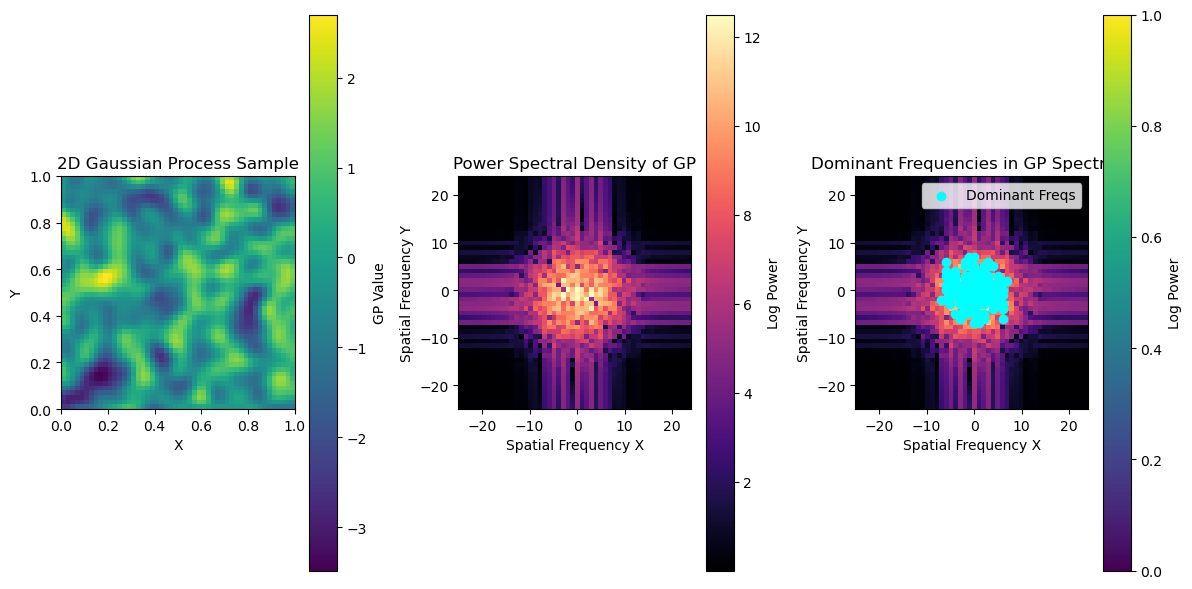

(np.float64(0.0),
 np.float64(1.0),
 [(np.float64(0.0), np.float64(-7.000000000000001)),
  (np.float64(1.0), np.float64(-7.000000000000001)),
  (np.float64(-3.0), np.float64(-6.0)),
  (np.float64(2.0), np.float64(-6.0)),
  (np.float64(6.0), np.float64(-6.0)),
  (np.float64(-4.0), np.float64(-5.0)),
  (np.float64(-3.0), np.float64(-5.0)),
  (np.float64(-2.0), np.float64(-5.0)),
  (np.float64(0.0), np.float64(-5.0)),
  (np.float64(1.0), np.float64(-5.0)),
  (np.float64(2.0), np.float64(-5.0)),
  (np.float64(-2.0), np.float64(-4.0)),
  (np.float64(-1.0), np.float64(-4.0)),
  (np.float64(0.0), np.float64(-4.0)),
  (np.float64(4.0), np.float64(-4.0)),
  (np.float64(6.0), np.float64(-4.0)),
  (np.float64(-5.0), np.float64(-3.0)),
  (np.float64(-3.0), np.float64(-3.0)),
  (np.float64(-2.0), np.float64(-3.0)),
  (np.float64(-1.0), np.float64(-3.0)),
  (np.float64(0.0), np.float64(-3.0)),
  (np.float64(1.0), np.float64(-3.0)),
  (np.float64(2.0), np.float64(-3.0)),
  (np.float64(4.0), np.float6

In [3]:
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt

# Define GP parameters
Nx, Ny = 50, 50  # Grid size
length_scale = 0.05  # GP length scale
sigma_f = 1.0  # GP signal variance

# Generate 2D grid
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x, y)
points = np.column_stack([X.ravel(), Y.ravel()])

# Compute RBF kernel matrix
distances = cdist(points, points, metric='euclidean')
kernel = np.exp(-distances**2 / (2 * length_scale**2))
kernel = kernel.reshape(Nx * Ny, Nx * Ny)

# Sample from multivariate normal with RBF covariance
gp_sample = multivariate_normal.rvs(mean=np.zeros(Nx * Ny), cov=kernel).reshape(Nx, Ny)

# Compute 2D Fourier Transform and PSD
fft_gp = np.fft.fft2(gp_sample)
psd_gp = np.abs(np.fft.fftshift(fft_gp))**2  # Shifted Power Spectral Density

# Compute frequency axes
fx = np.fft.fftshift(np.fft.fftfreq(Nx)) * Nx
fy = np.fft.fftshift(np.fft.fftfreq(Ny)) * Ny

# Find peak frequencies in the 2D PSD
peak_idx = np.unravel_index(np.argmax(psd_gp), psd_gp.shape)
dominant_freq_x = fx[peak_idx[1]]
dominant_freq_y = fy[peak_idx[0]]

# Find multiple peaks using a threshold (e.g., top 5%)
threshold = 0.05 * np.max(psd_gp)
peak_indices = np.argwhere(psd_gp > threshold)
dominant_frequencies = [(fx[j], fy[i]) for i, j in peak_indices]

# Plot results
plt.figure(figsize=(12, 6))

# Plot the GP sample
plt.subplot(1, 3, 1)
plt.imshow(gp_sample, cmap="viridis", extent=[0, 1, 0, 1])
plt.title("2D Gaussian Process Sample")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="GP Value")

# Plot the PSD
plt.subplot(1, 3, 2)
plt.imshow(np.log1p(psd_gp), cmap="magma", extent=[fx.min(), fx.max(), fy.min(), fy.max()])
plt.title("Power Spectral Density of GP")
plt.xlabel("Spatial Frequency X")
plt.ylabel("Spatial Frequency Y")
plt.colorbar(label="Log Power")

# Mark dominant frequencies
plt.subplot(1, 3, 3)
plt.imshow(np.log1p(psd_gp), cmap="magma", extent=[fx.min(), fx.max(), fy.min(), fy.max()])
plt.scatter([f[0] for f in dominant_frequencies], [f[1] for f in dominant_frequencies], color='cyan', label="Dominant Freqs")
plt.title("Dominant Frequencies in GP Spectrum")
plt.xlabel("Spatial Frequency X")
plt.ylabel("Spatial Frequency Y")
plt.legend()
plt.colorbar(label="Log Power")

plt.tight_layout()
plt.show()

# Display dominant frequency results
dominant_freq_x, dominant_freq_y, dominant_frequencies


## GP trained on city data

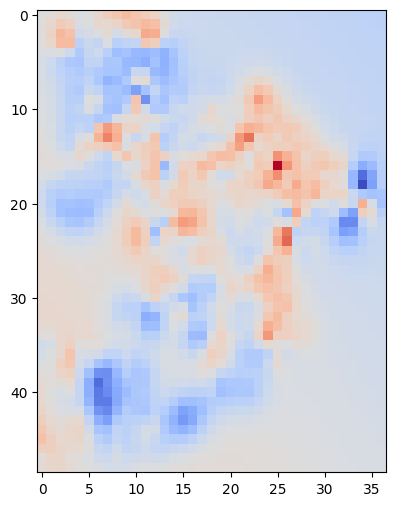

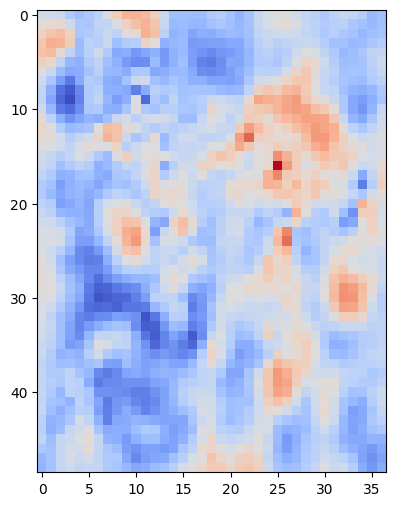

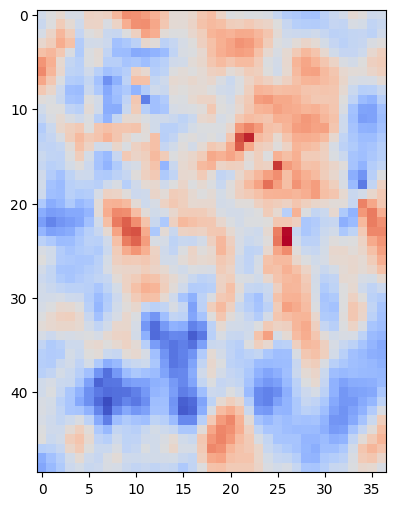

In [78]:
# gp_sample1 = np.flipud(mean_pred_ex.reshape(len(y_coords), len(x_coords)))
plt.figure(figsize=(12, 6))
plt.imshow(gp_sample1, cmap='coolwarm')

gp_sample2 = np.flipud(sample_preds_ex[0].reshape(len(y_coords), len(x_coords)))
plt.figure(figsize=(12, 6))
plt.imshow(gp_sample2, cmap='coolwarm')

gp_sample3 = np.flipud(sample_preds_ex[1].reshape(len(y_coords), len(x_coords)))
plt.figure(figsize=(12, 6))
plt.imshow(gp_sample3, cmap='coolwarm')

## GP Sample 1 (Mean)

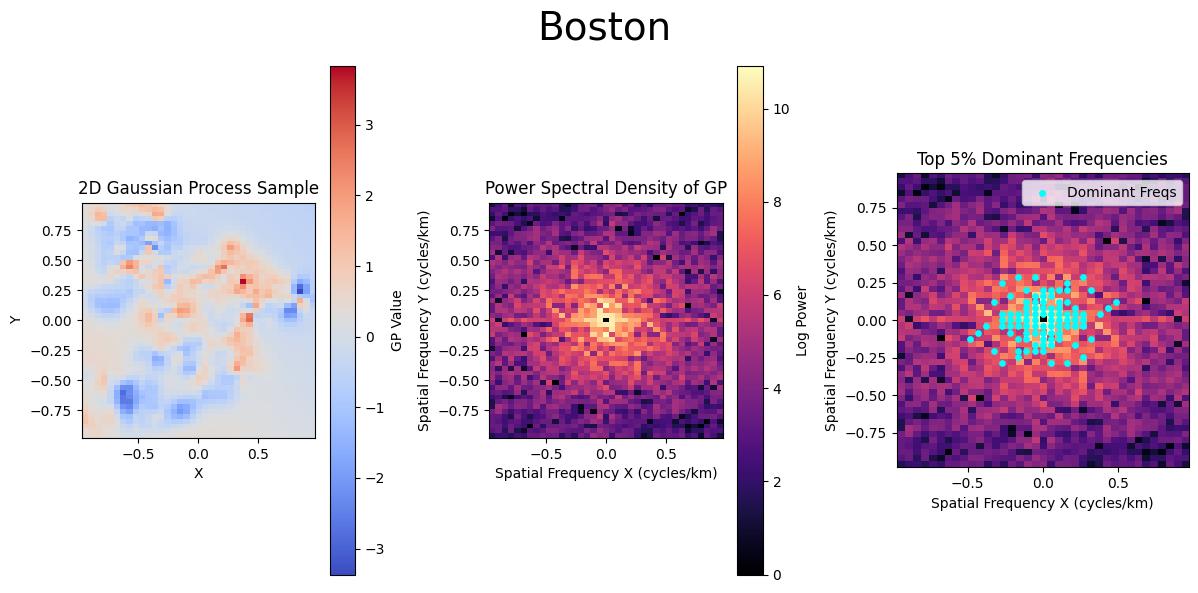

Peak frequency: fx = 0.000, fy = -0.122
Sample of top dominant frequencies (fx, fy):
[(-0.2702702702702703, -0.2857142857142857), (0.05405405405405406, -0.2857142857142857), (0.16216216216216217, -0.2857142857142857), (-0.16216216216216217, -0.24489795918367346), (0.2702702702702703, -0.24489795918367346), (-0.32432432432432434, -0.2040816326530612), (-0.16216216216216217, -0.2040816326530612), (-0.10810810810810811, -0.2040816326530612), (-0.05405405405405406, -0.2040816326530612), (0.0, -0.2040816326530612)]


In [77]:
# Compute 2D Fourier Transform and PSD
fft_gp = np.fft.fft2(gp_sample1)
psd_gp = np.abs(np.fft.fftshift(fft_gp))**2  # Shifted Power Spectral Density

# Compute frequency axes (correct spacing!)
Nx = gp_sample1.shape[1]
Ny = gp_sample1.shape[0]
dx = resolution/1000
dy = resolution/1000
fx = np.fft.fftshift(np.fft.fftfreq(Nx, d=dx))
fy = np.fft.fftshift(np.fft.fftfreq(Ny, d=dy))

# Find peak frequency in the PSD
peak_idx = np.unravel_index(np.argmax(psd_gp), psd_gp.shape)
dominant_freq_x = fx[peak_idx[1]]  # column → x
dominant_freq_y = fy[peak_idx[0]]  # row → y

# Flatten PSD and compute threshold for top 5%
flattened_psd = psd_gp.flatten()
threshold = np.percentile(flattened_psd, 95)

# Get indices of PSD values above the threshold
indices = np.argwhere(psd_gp >= threshold)

# Get corresponding frequencies
dominant_frequencies = []
for i, j in indices:
    freq_x = fx[j]  # j = column = fx
    freq_y = fy[i]  # i = row = fy
    dominant_frequencies.append((freq_x, freq_y))

# --- Plotting ---
plt.figure(figsize=(12, 6))
plt.suptitle(f'{city}', fontsize=28)

# GP Sample
plt.subplot(1, 3, 1)
plt.imshow(gp_sample1, cmap="coolwarm", extent=[fx.min(), fx.max(), fy.min(), fy.max()])
plt.title("2D Gaussian Process Sample")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="GP Value")

# PSD
plt.subplot(1, 3, 2)
plt.imshow(np.log1p(psd_gp), cmap="magma", extent=[fx.min(), fx.max(), fy.min(), fy.max()])
plt.title("Power Spectral Density of GP")
plt.xlabel(f"Spatial Frequency X (cycles/km)")
plt.ylabel(f"Spatial Frequency Y (cycles/km)")
plt.colorbar(label="Log Power")

# Dominant Frequencies Overlay
plt.subplot(1, 3, 3)
plt.imshow(np.log1p(psd_gp), cmap="magma", extent=[fx.min(), fx.max(), fy.min(), fy.max()])
plt.scatter(
    [f[0] for f in dominant_frequencies],
    [f[1] for f in dominant_frequencies],
    color='cyan', s=15, label="Dominant Freqs"
)
plt.title("Top 5% Dominant Frequencies")
plt.xlabel(f"Spatial Frequency X (cycles/km)")
plt.ylabel(f"Spatial Frequency Y (cycles/km)")
plt.legend()

plt.tight_layout()
plt.show()

# Display results
print(f"Peak frequency: fx = {dominant_freq_x:.3f}, fy = {dominant_freq_y:.3f}")
print("Sample of top dominant frequencies (fx, fy):")
print(dominant_frequencies[:10])  # show just a few

In [92]:
list_freq = []
for item in dominant_frequencies:
    list_freq.append(item[0])
    list_freq.append(item[1])
list_freq

[0.03937007874015748,
 -0.9243697478991596,
 -0.03937007874015748,
 -0.8403361344537814,
 0.03937007874015748,
 -0.7983193277310924,
 -0.07874015748031496,
 -0.7563025210084033,
 -0.03937007874015748,
 -0.7563025210084033,
 0.07874015748031496,
 -0.7563025210084033,
 -0.03937007874015748,
 -0.7142857142857142,
 0.0,
 -0.7142857142857142,
 0.03937007874015748,
 -0.7142857142857142,
 0.11811023622047244,
 -0.7142857142857142,
 -0.07874015748031496,
 -0.6722689075630252,
 0.0,
 -0.6722689075630252,
 0.03937007874015748,
 -0.6722689075630252,
 0.23622047244094488,
 -0.6722689075630252,
 -0.15748031496062992,
 -0.6302521008403361,
 -0.11811023622047244,
 -0.6302521008403361,
 -0.07874015748031496,
 -0.6302521008403361,
 -0.03937007874015748,
 -0.6302521008403361,
 0.0,
 -0.6302521008403361,
 0.07874015748031496,
 -0.6302521008403361,
 0.23622047244094488,
 -0.6302521008403361,
 -0.23622047244094488,
 -0.588235294117647,
 -0.19685039370078738,
 -0.588235294117647,
 -0.11811023622047244,
 -0.

(array([  8.,  10.,  40., 246., 394., 531., 229.,  38.,   7.,   9.]),
 array([-1.57480315, -1.25984252, -0.94488189, -0.62992126, -0.31496063,
         0.        ,  0.31496063,  0.62992126,  0.94488189,  1.25984252,
         1.57480315]),
 <BarContainer object of 10 artists>)

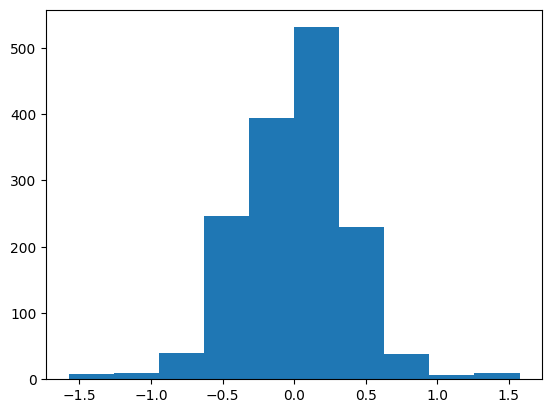

In [93]:
plt.hist(list_freq, bins=10)

Bridging the dominant frequency with the length scale of the Gaussian process (GP)

$\begin{equation}
    S(\omega) \propto \exp\left(-\frac{l^2\omega^2}{2}\right) \rightarrow l \propto \frac{1}{2\pi f_{\text{dominant}}}
\end{equation}
    $

In [107]:
x_lengthscales = []
y_lengthscales = []
for (x,y) in dominant_frequencies:
    if x != 0.0 and y!= 0.0: # filter out the zeroes
        lsx = (1/(2*np.pi*x)) #* (1000/resolution)
        x_lengthscales.append(lsx)
        lsy = (1/(2*np.pi*y)) #* (1000/resolution)
        y_lengthscales.append(lsy)

In [95]:
(xmax-xmin)/1000

25.13733251475729

(0.0, 5.0)

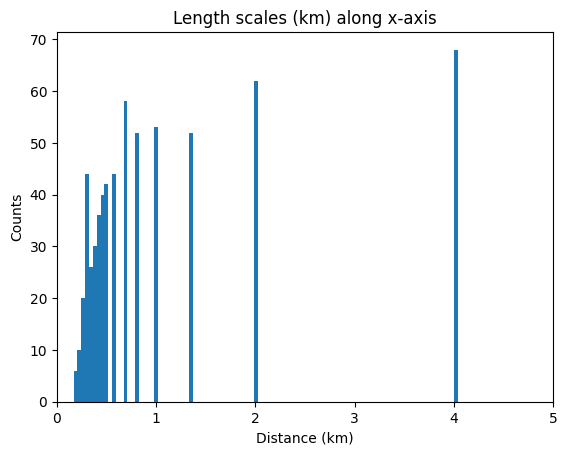

In [105]:
plt.hist(np.abs(x_lengthscales), bins=100)
plt.title('Length scales (km) along x-axis')
plt.xlabel('Distance (km)')
plt.ylabel('Counts')
plt.xlim(0,5)

In [33]:
(ymax-ymin)/1000

31.54305626580119

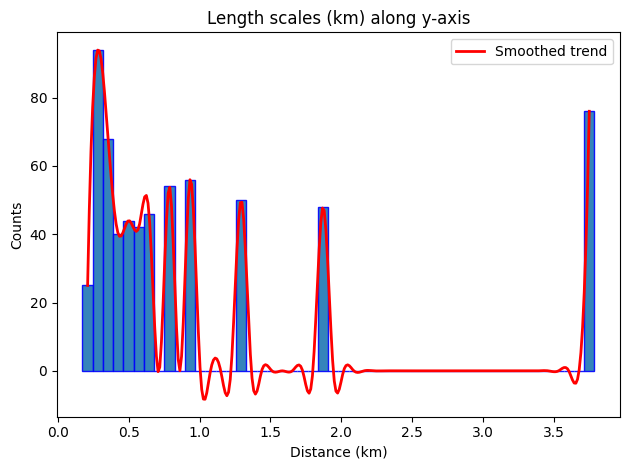

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Assume `length_scales_y` is your 1D array of length scales
counts, bins, _ = plt.hist(np.abs(y_lengthscales), bins=50, edgecolor='blue', alpha=0.9)

# Compute bin centers (x) and heights (y)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
heights = counts

# Smooth curve using spline interpolation
xnew = np.linspace(bin_centers.min(), bin_centers.max(), 300)
spline = make_interp_spline(bin_centers, heights, k=3)  # cubic spline
y_smooth = spline(xnew)

# Plot histogram again
# plt.hist(np.abs(y_lengthscales), bins=50, edgecolor='blue')
plt.plot(xnew, y_smooth, color='red', linewidth=2, label="Smoothed trend")

# Labels
plt.title("Length scales (km) along y-axis")
plt.xlabel("Distance (km)")
plt.ylabel("Counts")
plt.legend()
plt.tight_layout()
plt.show()

1. change the set of grid points
    divide by a thousand (m->km)
2. remove all normalizations!
    don't standardize z_detrended, still remove the trend
3. change it to celsius!
4. GPUs
5. to prevent overfitting, just do cross-validation 
6. in generating samples from the GP, use pred.samples() instead of using the mean (or maybe include the mean + 4 different sets of samples)

SCALE!

## GP Sample 2

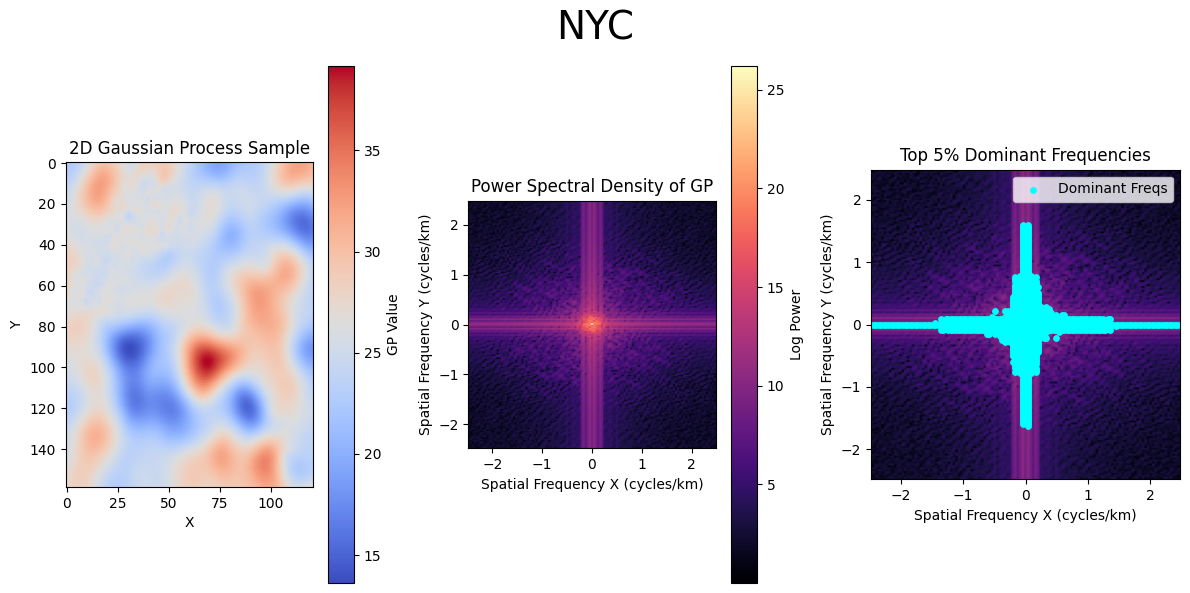

Peak frequency: fx = 0.000, fy = 0.000
Sample of top dominant frequencies (fx, fy):
[(0.04132231404958677, -1.6352201257861636), (-0.04132231404958677, -1.6037735849056605), (0.04132231404958677, -1.6037735849056605), (-0.04132231404958677, -1.5723270440251573), (0.04132231404958677, -1.5723270440251573), (-0.04132231404958677, -1.5408805031446542), (0.04132231404958677, -1.5408805031446542), (-0.04132231404958677, -1.509433962264151), (0.04132231404958677, -1.509433962264151), (-0.04132231404958677, -1.4779874213836477)]


In [35]:
# Compute 2D Fourier Transform and PSD
fft_gp = np.fft.fft2(gp_sample2)
psd_gp = np.abs(np.fft.fftshift(fft_gp))**2  # Shifted Power Spectral Density

# Compute frequency axes (correct spacing!)
Nx = gp_sample2.shape[1]
Ny = gp_sample2.shape[0]
dx = resolution/1000
dy = resolution/1000
fx = np.fft.fftshift(np.fft.fftfreq(Nx, d=dx))
fy = np.fft.fftshift(np.fft.fftfreq(Ny, d=dy))

# Find peak frequency in the PSD
peak_idx = np.unravel_index(np.argmax(psd_gp), psd_gp.shape)
dominant_freq_x = fx[peak_idx[1]]  # column → x
dominant_freq_y = fy[peak_idx[0]]  # row → y

# Flatten PSD and compute threshold for top 5%
flattened_psd = psd_gp.flatten()
threshold = np.percentile(flattened_psd, 95)

# Get indices of PSD values above the threshold
indices = np.argwhere(psd_gp >= threshold)

# Get corresponding frequencies
dominant_frequencies = []
for i, j in indices:
    freq_x = fx[j]  # j = column = fx
    freq_y = fy[i]  # i = row = fy
    dominant_frequencies.append((freq_x, freq_y))

# --- Plotting ---
plt.figure(figsize=(12, 6))
plt.suptitle(f'{city}', fontsize=28)

# GP Sample
plt.subplot(1, 3, 1)
plt.imshow(gp_sample2, cmap="coolwarm")# extent=[fx.min(), fx.max(), fy.min(), fy.max()])
plt.title("2D Gaussian Process Sample")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="GP Value")

# PSD
plt.subplot(1, 3, 2)
plt.imshow(np.log1p(psd_gp), cmap="magma", extent=[fx.min(), fx.max(), fy.min(), fy.max()])
plt.title("Power Spectral Density of GP")
plt.xlabel(f"Spatial Frequency X (cycles/km)")
plt.ylabel(f"Spatial Frequency Y (cycles/km)")
plt.colorbar(label="Log Power")

# Dominant Frequencies Overlay
plt.subplot(1, 3, 3)
plt.imshow(np.log1p(psd_gp), cmap="magma", extent=[fx.min(), fx.max(), fy.min(), fy.max()])
plt.scatter(
    [f[0] for f in dominant_frequencies],
    [f[1] for f in dominant_frequencies],
    color='cyan', s=15, label="Dominant Freqs"
)
plt.title("Top 5% Dominant Frequencies")
plt.xlabel(f"Spatial Frequency X (cycles/km)")
plt.ylabel(f"Spatial Frequency Y (cycles/km)")
plt.legend()

plt.tight_layout()
plt.show()

# Display results
print(f"Peak frequency: fx = {dominant_freq_x:.3f}, fy = {dominant_freq_y:.3f}")
print("Sample of top dominant frequencies (fx, fy):")
print(dominant_frequencies[:10])  # show just a few

In [70]:
list_freq = []
for item in dominant_frequencies:
    list_freq.append(item[0])
    list_freq.append(item[1])
list_freq

[-0.04132231404958677,
 -0.8490566037735849,
 0.08264462809917354,
 -0.8176100628930818,
 -0.08264462809917354,
 -0.7861635220125787,
 -0.04132231404958677,
 -0.7861635220125787,
 0.08264462809917354,
 -0.7861635220125787,
 0.1239669421487603,
 -0.7861635220125787,
 -0.20661157024793386,
 -0.7547169811320755,
 -0.08264462809917354,
 -0.7547169811320755,
 0.08264462809917354,
 -0.7547169811320755,
 0.1239669421487603,
 -0.7547169811320755,
 -0.08264462809917354,
 -0.7232704402515723,
 -0.33057851239669417,
 -0.6918238993710691,
 -0.2892561983471074,
 -0.6918238993710691,
 0.08264462809917354,
 -0.6918238993710691,
 -0.2892561983471074,
 -0.660377358490566,
 -0.16528925619834708,
 -0.660377358490566,
 -0.04132231404958677,
 -0.660377358490566,
 0.04132231404958677,
 -0.660377358490566,
 0.08264462809917354,
 -0.660377358490566,
 -0.16528925619834708,
 -0.6289308176100629,
 -0.1239669421487603,
 -0.6289308176100629,
 0.1239669421487603,
 -0.6289308176100629,
 0.2479338842975206,
 -0.62893

(array([ 16.,  69., 148., 303., 394., 429., 311., 160.,  74.,  22.]),
 array([-1.03305785, -0.82644628, -0.61983471, -0.41322314, -0.20661157,
         0.        ,  0.20661157,  0.41322314,  0.61983471,  0.82644628,
         1.03305785]),
 <BarContainer object of 10 artists>)

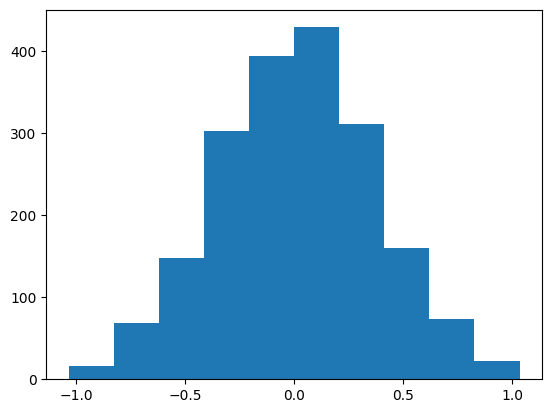

In [71]:
plt.hist(list_freq, bins=10)

Bridging the dominant frequency with the length scale of the Gaussian process (GP)

$\begin{equation}
    S(\omega) \propto \exp\left(-\frac{l^2\omega^2}{2}\right) \rightarrow l \propto \frac{1}{f_{\text{dominant}}}
\end{equation}
    $

In [75]:
x_lengthscales = []
y_lengthscales = []
for (x,y) in dominant_frequencies:
    if x != 0.0 and y!= 0.0: # filter out the zeroes
        lsx = 1/x
        x_lengthscales.append(lsx)
        lsy = 1/y
        y_lengthscales.append(lsy)

Text(0, 0.5, 'Counts')

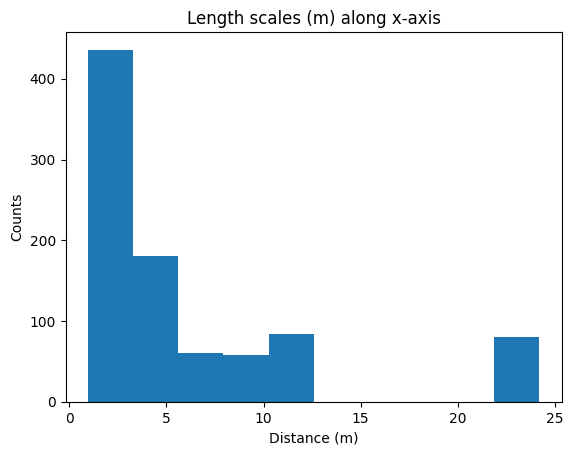

In [76]:
plt.hist(np.abs(x_lengthscales))
plt.title('Length scales (m) along x-axis')
plt.xlabel('Distance (m)')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

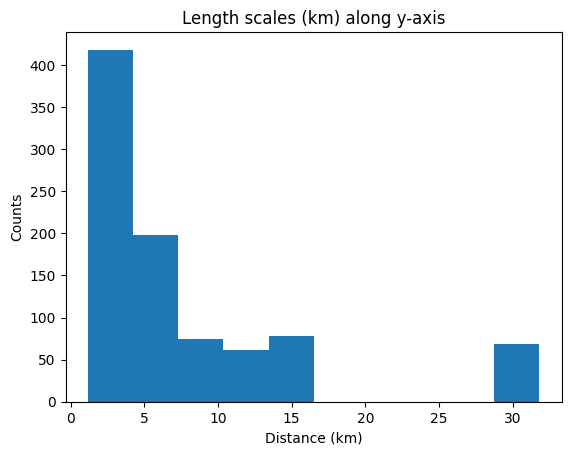

In [77]:
plt.hist(np.abs(y_lengthscales))
plt.title('Length scales (km) along y-axis')
plt.xlabel('Distance (km)')
plt.ylabel('Counts')